Notebook on time series causality, part 4

Here we look into what might happen in local projections of dependent variable $Y_{2}$ on independent variable $Y_{1}$ when different lag structure of independent variable is used on RHS of the local projection regression. The result is that it depends on the assumed dynamic causal structure between $Y_{2}$ and $Y_{1}$!

First we simulate data from a know VAR process, with different settings in each case. Then form the known VAR we calculate what the impulse reponse of $Y_{2}$ on $Y_{1}$ to see what the real causal effects are. We compare these to following (mis-specified) local projections:

FILL.

Data generating process is such that

- in case 1, $Y_{1}$ affects $Y_{2}$ negatively on three lags.
- in case 2,  $Y_{1}$ affects $Y_{2}$ positively on first lag and negatively on lags 2 and 3.

## Imports

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [4]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
def fit_svar_and_irfs(df_in, lags, irf_horizon):
    """
    We 'guess' the correct DGP and fit such model to simulated data.
    
    For structural identification/impulse responses we use Cholesky decomposition such that
    structural shock for $y_{2,t}$, $\omega_{2,t}$, does not contemporaneously affect $y_{1,t}$.
    Does not eally matter in this case, as there's no contemporaneous causal link, and structural
    IRFs will be the same as reduced-form IRFs. 
    """
    # VAR
    model_var = sm.tsa.VAR(df_in.copy())
    res_var = model_var.fit(maxlags=lags)
    irf_var = res_var.irf(irf_horizon)

    # SVAR
    D = np.asarray([
        ["E", 0],
        ["E", "E"],
    ])
    model_svar = sm.tsa.SVAR(df_in.copy(), svar_type='A', A=D)
    res_svar = model_svar.fit(maxlags=lags)
    irf_svar = res_svar.irf(irf_horizon)
    
    fig = irf_svar.plot()
    fig.suptitle(fig._suptitle.get_text(), fontsize=12)
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(top=0.88, wspace=0.3)
    _, _, ax, _ = fig.get_axes()
    for h in range(4):
        print("Estimated effect of y1_t on y2_t+{} is about {:.2f}".format(h, irf_svar.svar_irfs[h, 1, 0]))

def prepare_lp_data(df_in):
    """Prepare data for OLS LP"""
    gg = pd.DataFrame()
    gg["y2"] = df_in["y2"].copy()
    gg["y1"] = df_in["y1"].copy()

    for l in range(6):
        gg["y1_l"+str(l+1)] = df_in["y1"].copy()
        gg["y2_l"+str(l+1)] = df_in["y2"].copy()
    gg = gg.iloc[1:] # remove y_0 row

    for l in range(6):
        gg["y1_l"+str(l+1)] = gg["y1_l"+str(l+1)].shift(l+1)
        gg["y2_l"+str(l+1)] = gg["y2_l"+str(l+1)].shift(l+1)

    gg.dropna(inplace=True)
    return gg

def local_projections(df_in):
    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l3 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y1_l3 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

## Case 1

### DGP

$$
\begin{align*}
Y_{t} & = \beta_{1} Y_{t-1} + \beta_{} Y_{t-2} + \beta_{3} Y_{t-3} + u_{t}
\end{align*}
$$

where

$
\begin{align*}
Y_t = \begin{bmatrix} Y_{1,t} \\ Y_{2,t} \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_1 = \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} = 
\begin{bmatrix} 0.8 & 0 \\ -0.5 & 0.4 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_2 = \begin{bmatrix} \beta_{2, 11} & \beta_{2, 12} \\ \beta_{2, 21} & \beta_{2, 22} \end{bmatrix} = 
\begin{bmatrix} 0.1 & 0 \\ -0.2 & 0.2 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_3 = \begin{bmatrix} \beta_{3, 11} & \beta_{3, 12} \\ \beta_{3, 21} & \beta_{3, 22} \end{bmatrix} =
\begin{bmatrix} 0.05 & 0 \\ -0.1 & 0 \end{bmatrix}
\end{align*}
$.


Shocks are uncorrelated with covariance matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$


### Simualate data according to DGP

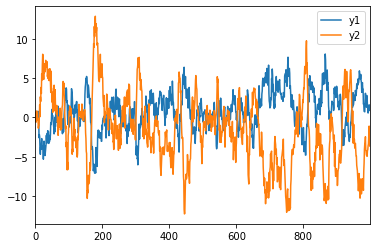

In [6]:
# With this, negativ effects for both contemporaneous and lagged variable
initial_state = [0, 0, 0, 0, 0, 0]
coefs = np.array([
       [0.8, 0, 0.1, 0, 0.05, 0], 
       [-0.5, 0.4, -0.2, 0.2, -0.1, 0],
]).flatten(order="C")
corr = np.array([
    [1, 0],
    [0, 1],
])
stds = [1, 1]
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y1":[np.nan, np.nan, np.nan, np.nan], "y2":[np.nan, np.nan, np.nan, np.nan]}, index=[0, 1, 2, 3])
mod = sm.tsa.VARMAX(endog, order=(3, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
#print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df_case1 = pd.DataFrame(mod.simulate(params=params, nsimulations=1000, initial_state=initial_state))
_ = df_case1.plot()

### Fit a SVAR model to simulated data

Estimated effect of y1_t on y2_t+0 is about 0.03
Estimated effect of y1_t on y2_t+1 is about -0.43
Estimated effect of y1_t on y2_t+2 is about -0.79
Estimated effect of y1_t on y2_t+3 is about -1.03


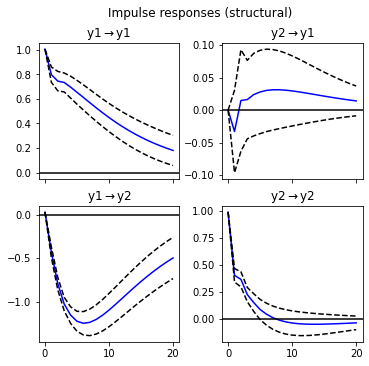

In [7]:
fit_svar_and_irfs(df_case1, lags=3, irf_horizon=20)

### Local projection regressions

In [8]:
df_lp = prepare_lp_data(df_case1)
local_projections(df_lp)

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              5135.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                        0.00
Time:                        17:40:25   Log-Likelihood:                         -1561.6
No. Observations:                 993   AIC:                                      3129.
Df Residuals:                     990   BIC:                                      3144.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Case 2

### DGP

### Simualate data according to DGP

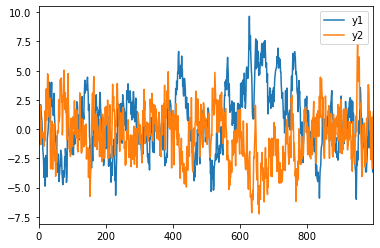

In [9]:
# With this, negativ effects for both contemporaneous and lagged variable
initial_state = [0, 0, 0, 0, 0, 0]
coefs = np.array([
       [0.8, 0, 0.1, 0, 0.05, 0], 
       [0.6, 0.4, -0.15, 0.2, -0.7, 0],
]).flatten(order="C")
corr = np.array([
    [1, 0],
    [0, 1],
])
stds = [1, 1]
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y1":[np.nan, np.nan, np.nan, np.nan], "y2":[np.nan, np.nan, np.nan, np.nan]}, index=[0, 1, 2, 3])
mod = sm.tsa.VARMAX(endog, order=(3, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
#print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df_case2 = pd.DataFrame(mod.simulate(params=params, nsimulations=1000, initial_state=initial_state))
_ = df_case2.plot()

### Fit a SVAR model to simulated data

Estimated effect of y1_t on y2_t+0 is about 0.02
Estimated effect of y1_t on y2_t+1 is about 0.60
Estimated effect of y1_t on y2_t+2 is about 0.60
Estimated effect of y1_t on y2_t+3 is about -0.06


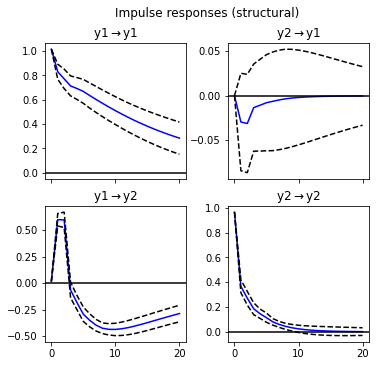

In [10]:
fit_svar_and_irfs(df_case2, lags=3, irf_horizon=20)

### Local projection regressions

In [11]:
df_lp = prepare_lp_data(df_case2)
local_projections(df_lp)

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.535
Method:                 Least Squares   F-statistic:                              382.1
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                   8.37e-165
Time:                        17:40:25   Log-Likelihood:                         -1833.8
No. Observations:                 993   AIC:                                      3674.
Df Residuals:                     990   BIC:                                      3688.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------